In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
semSegClasses = {  
     0: [0, 0, 0],         # None 
     1: [70, 70, 70],      # Buildings 
     2: [190, 153, 153],   # Fences 
     3: [72, 0, 90],       # Other 
     4: [220, 20, 60],     # Pedestrians 
     5: [153, 153, 153],   # Poles 
     6: [157, 234, 50],    # RoadLines 
     7: [128, 64, 128],    # Roads 
     8: [244, 35, 232],    # Sidewalks 
     9: [107, 142, 35],    # Vegetation 
     10: [0, 0, 255],      # Vehicles 
     11: [102, 102, 156],  # Walls 
     12: [220, 220, 0]     # TrafficSigns 
 } 

In [4]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras

In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_Segmentation/utils
import helpers

/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/utils


In [6]:
rgb_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/rgb'
seg_dir='/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/seg'

images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

In [7]:
def get_label_info(csv_path):

    filename, file_extension = os.path.splitext(csv_path)
    if not file_extension == ".csv":
        return ValueError("File is not a CSV!")

    class_names = []
    label_values = []
    with open(csv_path, 'r') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        header = next(file_reader)
        for row in file_reader:
            class_names.append(row[0])
            label_values.append([int(row[1]), int(row[2]), int(row[3])])
        # print(class_dict)
    return class_names, label_values

def one_hot_it(label, label_values):
 
    # https://stackoverflow.com/questions/14859458/how-to-check-if-all-values-in-the-columns-of-a-numpy-matrix-are-the-same
    semantic_map = []
    for colour in label_values:
        # colour_map = np.full((label.shape[0], label.shape[1], label.shape[2]), colour, dtype=int)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map
    
def reverse_one_hot(image):


    x = np.argmax(image, axis = -1)
    return x

In [40]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/rgb/00.jpg")
depth_img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/depth/02.png",-1)
label_image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/seg/02.png")

In [41]:
print(depth_img.max())

24771


In [42]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label_image = cv2.cvtColor(label_image,cv2.COLOR_BGR2RGB)
classnames,label_values = helpers.get_label_info('/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/classes.csv')


mask1 = np.float32(helpers.one_hot_it(label_image,label_values))
mask1 = helpers.reverse_one_hot(mask1)
mask1 = mask1.astype('float32')


image=np.array(img)
newimg=np.array(mask1)

In [43]:
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)

In [45]:
print(newimg)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


In [46]:
cam_mtx = np.array([
    [358.5, 0.0,   512.0],
    [0.0,   358.5, 256.0],
    [0.0,   0.0,   1.0],
    
])

k=cam_mtx

print( k[1][2])

256.0


In [47]:

from numpy import asarray


depth = asarray(depth_img)

print('Data Type: %s' % depth.dtype)
print('Min: %.3f, Max: %.3f' % (depth.min(), depth.max()))
depth = depth.astype('float32')
depth /= 100.0
print('Min: %.3f, Max: %.3f' % (depth.min(), depth.max()))

print(depth)

Data Type: uint16
Min: 0.000, Max: 24771.000
Min: 0.000, Max: 247.710
[[0.   0.   0.   ... 8.69 8.68 8.66]
 [0.   0.   0.   ... 8.69 8.68 8.66]
 [0.   0.   0.   ... 8.69 8.68 8.66]
 ...
 [2.89 2.89 2.89 ... 2.89 2.89 2.89]
 [2.88 2.88 2.88 ... 2.88 2.88 2.88]
 [2.87 2.87 2.87 ... 2.87 2.87 2.87]]


In [48]:
def xy_from_depth(depth, k):

   
    # Get the shape of the depth tensor
    sz = depth.shape

    # Grab required parameters from the K matrix
    f  = k[0][0]
    px = k[0][2]
    py = k[1][2]


    
    # Generate a grid of coordinates corresponding to the shape of the depth map
    u, v = np.meshgrid(np.arange(1,sz[1] + 1,1), np.arange(1,sz[0] + 1,1))

    # Compute x and y coordinates
    x = ((u -px) * depth) / f
    y = ((-v +py) * depth) / f 

    
    return x, y

In [49]:
    sz = depth.shape

print(sz[0])

print(sz[1])

512
1024


In [50]:
np.array(depth.max())

array(247.71, dtype=float32)

In [51]:
k=cam_mtx

z = depth


x, y = xy_from_depth(depth, k)

# print(x)
# print(y)

# print('x[250,250] = ' + str(x[250, 250]))
# print('y[250,250] = ' + str(y[250, 250]))
# print('z[250,250] = ' + str(z[250, 250]) + '\n')

# print('x[400,400] = ' + str(x[400, 400]))
# print('y[400,400] = ' + str(y[400, 400]))
# print('z[400,400] = ' + str(z[400, 400]) + '\n')

-16.263235626859146
-4.255732324831655
2.87


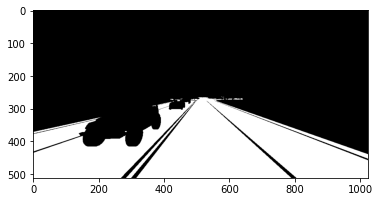

In [52]:
# Get road mask by choosing pixels in segmentation output with value 7
road_mask = np.zeros(newimg.shape)
road_mask[newimg == 7] = 1



plt.imshow(road_mask,cmap='gray')


x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = z[road_mask == 1]
xyz_ground = np.stack((x_ground, y_ground, z_ground))



print(x_ground.min())
print(y_ground.min())
print(z_ground.min())


In [53]:
def compute_plane(xyz):
    """
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0
    Arguments:
    xyz -- tensor of dimension (3, N), contains points needed to fit plane.
    k -- tensor of dimension (3x3), the intrinsic camera matrix
    Returns:
    p -- tensor of dimension (1, 4) containing the plane parameters a,b,c,d
    """
    ctr = xyz.mean(axis=1)
    normalized = xyz - ctr[:, np.newaxis]
    M = np.dot(normalized, normalized.T)

    p = np.linalg.svd(M)[0][:, -1]
    d = np.matmul(p, ctr)

    p = np.append(p, -d)

    # Correct plane
    # p = [0.0, 1.0, 0.0, -1.5]
    return p


def dist_to_plane(plane, x, y, z):
    """
    Computes distance between points provided by their x, and y, z coordinates
    and a plane in the form ax+by+cz+d = 0
    Arguments:
    plane -- tensor of dimension (4,1), containing the plane parameters [a,b,c,d]
    x -- tensor of dimension (Nx1), containing the x coordinates of the points
    y -- tensor of dimension (Nx1), containing the y coordinates of the points
    z -- tensor of dimension (Nx1), containing the z coordinates of the points
    Returns:
    distance -- tensor of dimension (N, 1) containing the distance between points and the plane
    """
    a, b, c, d = plane

    return (a * x + b * y + c * z + d) / np.sqrt(a**2 + b**2 + c**2)

In [54]:
def ransac_plane_fit(xyz_data):

    
  # Set thresholds:
    num_itr = 100  # RANSAC maximum number of iterations
    min_num_inliers = 45000 # RANSAC minimum number of inliers
    distance_threshold =0.1  # Maximum distance from point to plane for point to be considered inlier
    max_inliers=0
    data_size=xyz_data.shape[1]
       
    for i in range(num_itr):
        # Step 1: Choose a minimum of 3 points from xyz_data at random.
        rand_index = np.random.choice(data_size, 3, replace=False)
        rand_points = xyz_data[:, rand_index]
        
        # Step 2: Compute plane model
        p = compute_plane(rand_points)
        
        # Step 3: Find number of inliers
        dist = np.abs(dist_to_plane(p, xyz_data[0,:], xyz_data[1,:], xyz_data[2,:]))
        n_inliers = np.sum(dist < distance_threshold)
        
        # Step 4: Check if the current number of inliers is greater than all previous iterations and keep the inlier set with the largest number of points.
        if  max_inliers < n_inliers:
            max_inliers = n_inliers
            inlier_set = xyz_data[:, dist <distance_threshold]

            #   if num_inliers > final_num_inliers:
            # final_num_inliers = num_inliers
            
        # Step 5: Check if stopping criterion is satisfied and break.         
        if max_inliers > min_num_inliers:
            break
        
    # Step 6: Recompute the model parameters using largest inlier set.
    output_plane = compute_plane(inlier_set)

    ### END CODE HERE ###
    
    return output_plane

In [55]:
p_final = ransac_plane_fit(xyz_ground)
print('Ground Plane: ' + str(p_final))

Ground Plane: [-3.48231243e-05  9.99913343e-01  1.31645094e-02  2.00960529e+00]


25.07830599535363
63.63280202953386
20.739916174980387
247.71
-128.79765777375076
-4.828340282998823
0.0


(512, 1024)

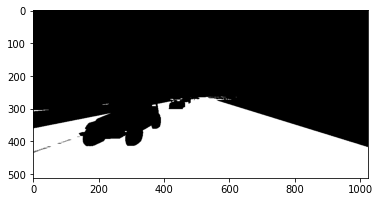

In [88]:
dist = np.abs(dist_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)
print(dist.max())
ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0

print(x.max())
print(y.max())
print(z.max())
print(x.min())
print(y.min())
print(z.min())

plt.imshow(ground_mask,cmap='gray')

ground_mask.shape

In [78]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/

/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data


In [79]:
!ls

'Copy of img1.png'   newimg.png        rgb   umetrics
 depth		     reshape_img.png   seg


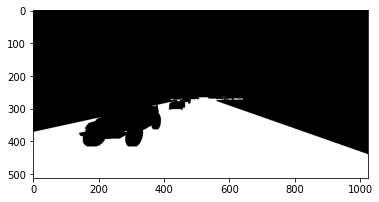

In [61]:
Fs=cv2.imread("/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/seg/fs_02.png")

plt.imshow(Fs)



In [94]:
Fs=true
prediction = ground_mask

In [101]:
truth = Fs[:, :, 0]


In [97]:
Fs.shape

(512, 1024, 3)

In [99]:
NewFs.shape

(512, 1024)

In [100]:
true = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Test_Segmentation/prof_data/seg/02.png")
prediction = newimg


In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(truth, prediction)
print("Mean IoU =", IOU_keras.result().numpy())


# #To calculate I0U for each class...
# values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
# print(values)
# class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[2,1]+ values[3,1]+ values[4,1])
# class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,1] + values[2,3] + values[1,2]+ values[3,2]+ values[4,2])




In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Test_segmentation/prof_data


In [85]:
!ls

'Copy of img1.png'   newimg.png        rgb   seg_metrics.py
 depth		     reshape_img.png   seg   umetrics


In [127]:
print(ground_mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [123]:
cv2.imshow(prediction)

plt.imshow(prediction)

DisabledFunctionError: ignored

In [120]:
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/Test_segmentation/prof_data/prediction.png,prediction.png')

TypeError: ignored

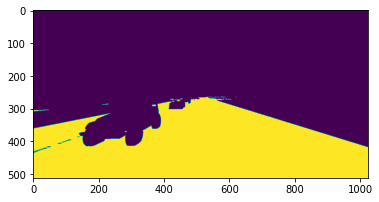

In [119]:
plt.imshow(ground_mask)

In [113]:
print(prediction)

[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]
 [7. 7. 7. ... 7. 7. 7.]]


In [106]:

import seg_metrics

seg_metrics.mean_dice(truth,prediction)#,'iou',mean_per_class=True)

InvalidArgumentError: ignored

In [105]:
prediction.shape

(512, 1024)

In [ ]:
import umetrics
from skimage.io import imread

y_true = truth
y_pred = prediction


# can now make the calculation strict, by only considering objects that have
# an IoU above a theshold as being true positives
result = umetrics.calculate(y_true, y_pred, strict=True, iou_threshold=0.5)

print(result.results)

In [76]:
!pip install umetrics

ERROR: Could not find a version that satisfies the requirement umetrics (from versions: none)
ERROR: No matching distribution found for umetrics


In [110]:
from keras import backend as K
def iou_coef(truth, prediction, smooth=1):
  intersection = K.sum(K.abs(truth * prediction), axis=[1,2,3])
  union = K.sum(truth,[1,2,3])+K.sum(prediction,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
print(iou_coef(truth,prediction))

In [128]:
from PIL import Image
import numpy as np

w, h = 512, 1024
ground_mask = np.zeros((h, w, 3), dtype=np.uint8)
ground_mask[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

NameError: ignored

In [129]:
Pred=reverse_one_hot(ground_mask)

In [132]:
print(Pred.max())

0
